This notebook showcases a “no‐feature‐engineering” pipeline for HAR: it begins by loading your 562-column processed train/test DataFrames (with “Activity” labels), encodes the labels, and splits the data into train/validation sets. It then trains several off-the-shelf classifiers—Decision Tree, XGBoost, Linear SVM (on full, PCA-reduced, time-only, and freq-only splits), as well as an LSTM wrapped as a sequence classifier—each evaluated via accuracy, precision, and recall. Along the way it visualizes PCA-reduced clusters with t-SNE and compares hyperparameter‐tuned SVMs. The goal is to benchmark how far “raw” processed features alone can take us, before adding any advanced feature extraction or deep-fusion models.

In [ ]:
!unzip /content/archive.zip -d /content/

Archive:  /content/archive.zip
  inflating: /content/test.csv       
  inflating: /content/train.csv      


In [ ]:

# ─── 0) Install prerequisites (Colab only) ─────────────────────────────────────
# !pip install requests scipy

import os
import zipfile
import requests
import numpy as np
import pandas as pd
from scipy.fft import rfft
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer



In [ ]:
# ─── 1) Download & unzip UCI HAR raw signals ───────────────────────────────────
UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
ZIP_PATH  = "UCI_HAR.zip"
DATA_DIR  = "UCI_HAR_Dataset"

if not os.path.exists(DATA_DIR):
    print("Downloading raw UCI HAR dataset…")
    r = requests.get(UCI_URL)
    with open(ZIP_PATH, "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall()      # creates folder 'UCI HAR Dataset'
    os.rename("UCI HAR Dataset", DATA_DIR)

# ─── 2) Load your feature CSVs (563 features) ─────────────────────────────────
train_df = pd.read_csv("./train.csv")  # adjust path if needed
test_df  = pd.read_csv("./test.csv")

In [ ]:
import pandas as pd
import numpy as np
train_df = train_df.drop(columns='subject')
train_df.head()
test_df = test_df.drop(columns='subject')
test_df.head()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,STANDING


In [ ]:
train_df['Activity'].value_counts()

,count
Activity,
LAYING,1407
STANDING,1374
SITTING,1286
WALKING,1226
WALKING_UPSTAIRS,1073
WALKING_DOWNSTAIRS,986


In [ ]:
print(train_df.shape)

(7352, 562)


# SVM

In [ ]:
# 1. Imports and setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

# If running in a notebook:
# %matplotlib inline


Combined shape: (7352, 562)
Sample columns: Index(['angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object')


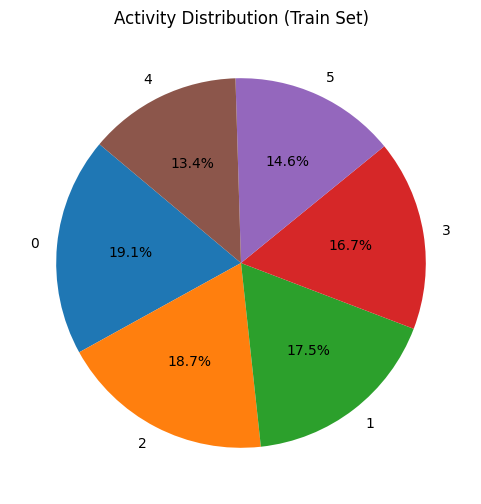

In [ ]:
import pandas as pd

# 1. Convert X_train (numpy) → DataFrame
#    If you don’t have explicit feature names, pandas will default to integers 0…99
#X_train_df = pd.DataFrame(X_train)
# Adjust these paths if your CSVs live elsewhere
train = X_train
test  = X_test

# 2. Add y_train as a new column called "Activity"
train["Activity"] = y_train
test["Activity"] = y_test

# 3. (Optional) Quick sanity check:
print("Combined shape:", X_train.shape)    # should be (n_samples, 101)
print("Sample columns:", X_train.columns[-5:])  # shows last few, including "Activity"

# 4. Now plot:
activity_counts = X_train["Activity"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Activity Distribution (Train Set)")
plt.show()

In [ ]:
# 2. Load and shuffle data
# Adjust these paths if your CSVs live elsewhere
train = X_train
test  = X_test

# Quick sanity check
print("Train shape:", train.shape)
print("Test  shape:", test.shape)
print("Any missing in train?", train.isnull().any().any())
print("Any missing in test? ", test.isnull().any().any())


Train shape: (7352, 562)
Test  shape: (2947, 562)
Any missing in train? False
Any missing in test?  False


In [ ]:
# # 3. Explore class distribution
# activity_counts = train["Activity"].value_counts()
# plt.figure(figsize=(6,6))
# plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', startangle=140)
# plt.title("Activity Distribution (Train Set)")
# plt.show()

In [ ]:
# Encode string labels as integers
le = LabelEncoder().fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc  = le.transform(y_test)

print("Classes:", le.classes_)

Classes: [0 1 2 3 4 5]


In [ ]:
# 5. Scale numeric features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
# 6. Define SVM parameter grid and perform 5-fold CV
param_grid = [
    {"kernel": ["rbf"],    "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]}
]

svm_cv = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=1)
svm_cv.fit(X_train_scaled, y_train_enc)

# Record best estimator
best_svm = svm_cv.best_estimator_

print("Best params:", svm_cv.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1407
           1       1.00      1.00      1.00      1286
           2       1.00      1.00      1.00      1374
           3       1.00      1.00      1.00      1226
           4       1.00      1.00      1.00       986
           5       1.00      1.00      1.00      1073

    accuracy                           1.00      7352
   macro avg       1.00      1.00      1.00      7352
weighted avg       1.00      1.00      1.00      7352

--- Train Metrics ---
Accuracy: 1.0000


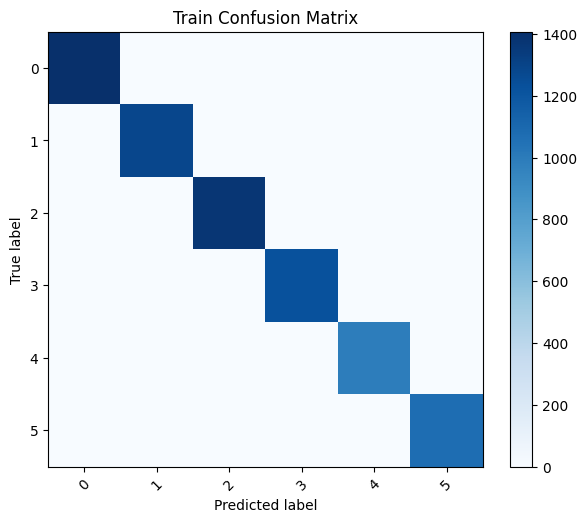

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       1.00      1.00      1.00       491
           2       1.00      1.00      1.00       532
           3       0.98      1.00      0.99       496
           4       1.00      0.95      0.97       420
           5       0.96      0.99      0.97       471

    accuracy                           0.99      2947
   macro avg       0.99      0.99      0.99      2947
weighted avg       0.99      0.99      0.99      2947

--- Test Metrics ---
Accuracy: 0.9895


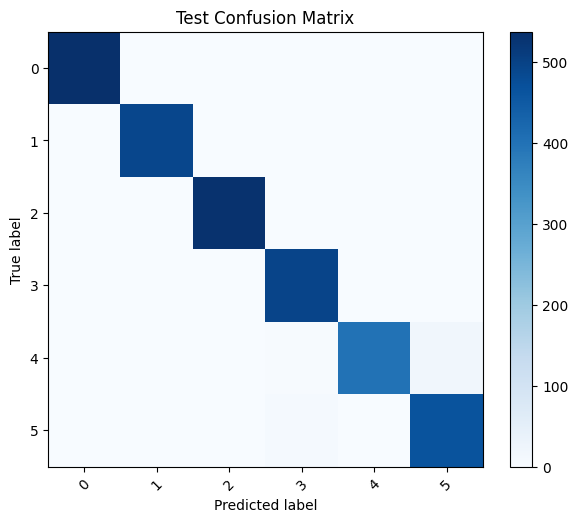

In [ ]:
# 7. Evaluate on train and test
for split, X, y in [("Train", X_train_scaled, y_train_enc),
                   ("Test",  X_test_scaled,  y_test_enc)]:
    y_pred = best_svm.predict(X)
    print(classification_report(y, y_pred))
    print(f"--- {split} Metrics ---")
    print(f"Accuracy: {best_svm.score(X, y):.4f}")
    #print(classification_report(y, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,5))
    plt.title(f"{split} Confusion Matrix")
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xticks(range(len(le.classes_)), le.classes_, rotation=45)
    plt.yticks(range(len(le.classes_)), le.classes_)
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [ ]:
train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,2
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,2
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,2
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,2
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819,5
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053,5
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811,5
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339,5


# PCA  + Mutliple models

Original features: 561 PCA reduced: 155
DecisionTree_Full: Train Acc=1.000, Test Acc=1.000, Train Prec=1.000, Test Prec=1.000, Train Rec=1.000, Test Rec=1.000
XGB_Full: Train Acc=1.000, Test Acc=1.000, Train Prec=1.000, Test Prec=1.000, Train Rec=1.000, Test Rec=1.000
LinearSVC_PCA: Train Acc=0.992, Test Acc=0.962, Train Prec=0.993, Test Prec=0.965, Train Rec=0.993, Test Rec=0.962
LinearSVC_Freq: Train Acc=0.980, Test Acc=0.938, Train Prec=0.981, Test Prec=0.943, Train Rec=0.981, Test Rec=0.937
LinearSVC_Time: Train Acc=0.993, Test Acc=0.961, Train Prec=0.994, Test Prec=0.964, Train Rec=0.994, Test Rec=0.961


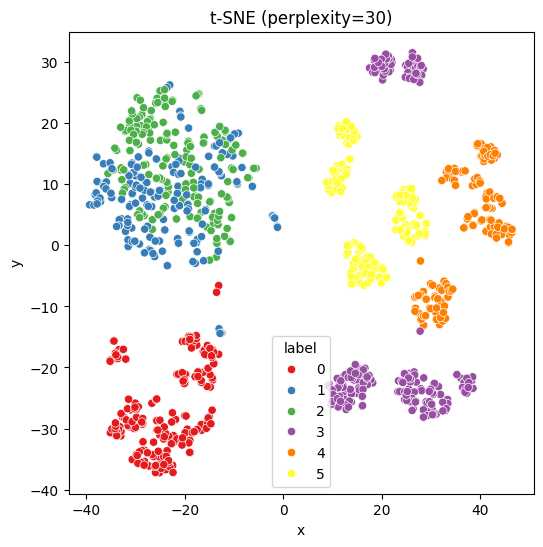

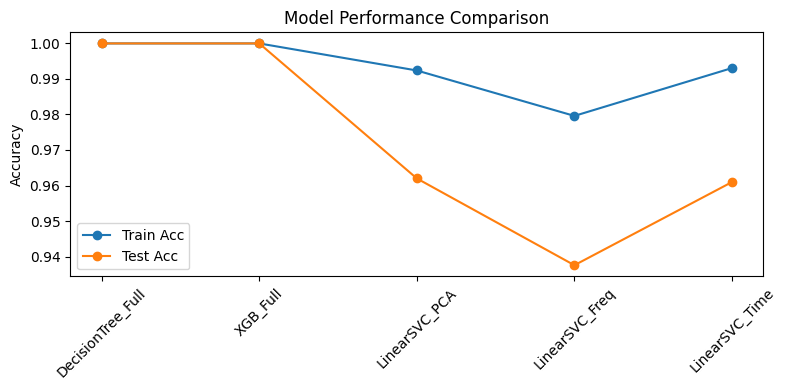

In [ ]:
# Human Activity Recognition Analysis Script

# 1. Imports and settings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn import tree, svm
from xgboost import XGBClassifier
# 2. Load data (adjust paths as needed)
# train_data = pd.read_csv("../input/human-activity-recognition-with-smartphones/train.csv")
# test_data  = pd.read_csv("../input/human-activity-recognition-with-smartphones/test.csv")
# 1. Start with original train and test
train_data = train
test_data = test

# 1. Assume you already have:
# train and test loaded.

# 2. Frequency-domain and Time-domain splits
f_train = train.filter(regex=r'^(f|s|a|A)')
f_test  = test.filter(regex=r'^(f|s|a|A)')
t_train = train.filter(regex=r'^(t|s|a|A)')
t_test  = test.filter(regex=r'^(t|s|a|A)')

# 3. Separate X and y
Xf_train = f_train.drop(columns=['Activity'])
yf_train = f_train['Activity']

Xf_test  = f_test.drop(columns=['Activity'])
yf_test  = f_test['Activity']

Xt_train = t_train.drop(columns=['Activity'])
yt_train = t_train['Activity']

Xt_test  = t_test.drop(columns=['Activity'])
yt_test  = t_test['Activity']

# 4. Full features (no filtering)
X_train_full = train.drop(columns=['Activity'])
y_train_full = train['Activity']

X_test_full  = test.drop(columns=['Activity'])
y_test_full  = test['Activity']

# 5. PCA on full features (fit on train, transform both train and test)
pca = PCA(n_components=0.99, random_state=42)
#X_pca = pca.fit_transform(X_full)
Xp_train = pca.fit_transform(X_train_full)
Xp_test  = pca.transform(X_test_full)

# 6. Final assignments (Xp, yp)
yp_train = y_train_full
yp_test  = y_test_full


# # 3. PCA on full features (retain 99% variance) — fit on train only, transform both train & test
# pca = PCA(n_components=0.99, random_state=42)
# Xp_train = pca.fit_transform(X_full_train)
# Xp_test  = pca.transform(X_full_test)

print("Original features:", X_train_full.shape[1], "PCA reduced:", Xp_train.shape[1])

# Now you have:
# - X_full_train, X_full_test, y_full_train, y_full_test
# - X_freq_train, X_freq_test, y_freq_train, y_freq_test
# - X_time_train, X_time_test, y_time_train, y_time_test
# - Xp_train, Xp_test, yp_train = y_full_train, yp_test = y_full_test


# 7. Label encoding
le = preprocessing.LabelEncoder().fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc  = le.transform(y_test)

# 8. Evaluation function
results = {}

def evaluate(model, name, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)
    tr_acc = model.score(X_tr, y_tr)
    te_acc = model.score(X_te, y_te)
    tr_prec = metrics.precision_score(y_tr, y_pred_tr, average='macro')
    te_prec = metrics.precision_score(y_te, y_pred_te, average='macro')
    tr_rec = metrics.recall_score(y_tr, y_pred_tr, average='macro')
    te_rec = metrics.recall_score(y_te, y_pred_te, average='macro')
    results[name] = {'train': (tr_acc, tr_prec, tr_rec),
                     'test':  (te_acc, te_prec, te_rec)}
    print(f"{name}: Train Acc={tr_acc:.3f}, Test Acc={te_acc:.3f},",
          f"Train Prec={tr_prec:.3f}, Test Prec={te_prec:.3f},",
          f"Train Rec={tr_rec:.3f}, Test Rec={te_rec:.3f}")

# 9. Train and evaluate models
evaluate(tree.DecisionTreeClassifier(random_state=42), 'DecisionTree_Full', X_train, X_test, y_train_enc, y_test_enc)
evaluate(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), 'XGB_Full', X_train, X_test, y_train_enc, y_test_enc)
evaluate(svm.LinearSVC(random_state=42, max_iter=2000), 'LinearSVC_PCA', Xp_train, Xp_test, le.transform(yp_train), le.transform(yp_test))
evaluate(svm.LinearSVC(random_state=42, max_iter=2000), 'LinearSVC_Freq', Xf_train, Xf_test, le.transform(yf_train), le.transform(yf_test))
evaluate(svm.LinearSVC(random_state=42, max_iter=2000), 'LinearSVC_Time', Xt_train, Xt_test, le.transform(yt_train), le.transform(yt_test))
# ─── NEW: Decision Tree on PCA-reduced features ─────────────────────────────
evaluate(tree.DecisionTreeClassifier(random_state=42),
         'DecisionTree_PCA',
         Xp_train, Xp_test,
         le.transform(yp_train), le.transform(yp_test))

# ─── NEW: XGBoost on PCA-reduced features ────────────────────────────────────
evaluate(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
         'XGB_PCA',
         Xp_train, Xp_test,
         le.transform(yp_train), le.transform(yp_test))

# 10. t-SNE visualization
def plot_tsne(X_data, labels, perplexity=30):
    embed = TSNE(n_components=2, perplexity=perplexity, random_state=42).fit_transform(X_data)
    df = pd.DataFrame({'x': embed[:,0], 'y': embed[:,1], 'label': labels})
    plt.figure(figsize=(6,6))
    sns.scatterplot(x='x', y='y', hue='label', data=df, legend='full', palette='Set1')
    plt.title(f"t-SNE (perplexity={perplexity})")
    plt.show()

plot_tsne(Xp_test[:1000], y_test_full.iloc[:1000])

# 11. Compare model accuracies
names = list(results.keys())
train_accs = [results[n]['train'][0] for n in names]
test_accs  = [results[n]['test'][0]  for n in names]

plt.figure(figsize=(8,4))
plt.plot(names, train_accs, marker='o', label='Train Acc')
plt.plot(names, test_accs,  marker='o', label='Test Acc')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
from scipy.special import softmax

def evaluate_model(model, name, X_tr, X_te, y_tr, y_te, cv_splits=10):
    """10-fold CV + full test metrics (with softmax on decision scores if needed)."""
    # 1) Cross-validate on training set
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
    cv_res = cross_validate(model, X_tr, y_tr, cv=cv,
                            scoring=scoring, n_jobs=-1)

    # 2) Fit full model & predict on test
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    # 3) Compute ROC-AUC
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_te)
        auc = roc_auc_score(y_te, y_probs, multi_class='ovr')
    elif hasattr(model, "decision_function"):
        # Convert decision scores to probabilities
        scores = model.decision_function(X_te)   # shape (n_samples, n_classes)
        # apply softmax per sample
        y_probs = softmax(scores, axis=1)
        auc = roc_auc_score(y_te, y_probs, multi_class='ovr')
    else:
        auc = np.nan

    # 4) Test-set metrics
    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_te, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_te, y_pred, average='macro', zero_division=0)
    cm   = confusion_matrix(y_te, y_pred)

    # 5) Print summary
    print(f"\n{name} – "
          f"CV Acc={cv_res['test_accuracy'].mean():.3f}±{cv_res['test_accuracy'].std():.3f}, "
          f"Test Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}, AUC={auc:.3f}")
    print("Confusion Matrix:\n", cm)

    # 6) Return if you want to store
    return {
        'cv_acc':    (cv_res['test_accuracy'].mean(), cv_res['test_accuracy'].std()),
        'test_acc':  acc,
        'test_prec': prec,
        'test_rec':  rec,
        'test_f1':   f1,
        'test_auc':  auc,
        'conf_mat':  cm
    }


In [ ]:
# # 9. Train and evaluate models
# evaluate_model(tree.DecisionTreeClassifier(random_state=42), 'DecisionTree_Full', X_train, X_test, y_train_enc, y_test_enc)
# evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), 'XGB_Full', X_train, X_test, y_train_enc, y_test_enc)
# evaluate_model(svm.LinearSVC(random_state=42, max_iter=2000), 'LinearSVC_PCA', Xp_train, Xp_test, le.transform(yp_train), le.transform(yp_test))
# evaluate_model(svm.LinearSVC(random_state=42, max_iter=2000), 'LinearSVC_Freq', Xf_train, Xf_test, le.transform(yf_train), le.transform(yf_test))
# evaluate_model(svm.LinearSVC(random_state=42, max_iter=2000), 'LinearSVC_Time', Xt_train, Xt_test, le.transform(yt_train), le.transform(yt_test))

In [ ]:
import pandas as pd

# 1) List your models (replace with your actual variables)
models = [
    ("DecisionTree_Full", tree.DecisionTreeClassifier(random_state=42), X_train, X_test, y_train_enc, y_test_enc),
    ("XGB_Full",          XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                          X_train, X_test, y_train_enc, y_test_enc),
    ("LinearSVC_PCA",     svm.LinearSVC(max_iter=2000, random_state=42),
                          Xp_train, Xp_test, le.transform(yp_train), le.transform(yp_test)),
    ("LinearSVC_Freq",    svm.LinearSVC(max_iter=2000, random_state=42),
                          Xf_train, Xf_test, le.transform(yf_train), le.transform(yf_test)),
    ("LinearSVC_Time",    svm.LinearSVC(max_iter=2000, random_state=42),
                          Xt_train, Xt_test, le.transform(yt_train), le.transform(yt_test)),
    # add your deep‐model wrappers similarly:
    # ("LSTM",           lstm_clf, X_train_raw, X_test_raw, y_train_int, y_test_int),
    # ("PINN",           pinn_clf, X_train_raw, X_test_raw, y_train_int, y_test_int),
    # ("Transformer",    transformer_clf, X_train_raw, X_test_raw, y_train_int, y_test_int),
]

# 2) Evaluate and collect results
records = []
for name, clf, X_tr, X_te, y_tr, y_te in models:
    print(f"--> {name}")
    res = evaluate_model(clf, name, X_tr, X_te, y_tr, y_te, cv_splits=10)
    # Flatten the cv_acc tuple into two fields
    cv_mean, cv_std = res.pop('cv_acc')
    record = {
        'Model':        name,
        'CV Acc Mean':  cv_mean,
        'CV Acc Std':   cv_std,
        'Test Acc':     res['test_acc'],
        'Test Prec':    res['test_prec'],
        'Test Rec':     res['test_rec'],
        'Test F1':      res['test_f1'],
        'Test AUC':     res['test_auc']
        # you can also store 'conf_mat': res['conf_mat'] if desired
    }
    records.append(record)

# 3) Build the DataFrame
df_results = pd.DataFrame.from_records(records)
df_results = df_results.set_index('Model')
print("\n=== Comparison Table ===")
print(df_results)


--> DecisionTree_Full

DecisionTree_Full – CV Acc=1.000±0.001, Test Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000, AUC=1.000
Confusion Matrix:
 [[537   0   0   0   0   0]
 [  0 491   0   0   0   0]
 [  0   0 532   0   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   0 420   0]
 [  0   0   0   0   0 471]]
--> XGB_Full

XGB_Full – CV Acc=1.000±0.000, Test Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000, AUC=1.000
Confusion Matrix:
 [[537   0   0   0   0   0]
 [  0 491   0   0   0   0]
 [  0   0 532   0   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   0 420   0]
 [  0   0   0   0   0 471]]
--> LinearSVC_PCA

LinearSVC_PCA – CV Acc=0.986±0.003, Test Acc=0.962, Prec=0.965, Rec=0.962, F1=0.962, AUC=0.997
Confusion Matrix:
 [[537   0   0   0   0   0]
 [  2 428  57   0   0   4]
 [  0  14 517   1   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   4 413   3]
 [  1   0   1  24   1 444]]
--> LinearSVC_Freq

LinearSVC_Freq – CV Acc=0.971±0.007, Test Acc=0.938, Prec=0.943, Rec=0.937, F1=0.938, AUC=0.99

## LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# 1. Prepare your data (assumes X_train, y_train are NumPy arrays)
#    X_train shape: (n_samples, timesteps, n_features)
#    y_train shape: (n_samples,)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tensor = torch.from_numpy(X_train.values).float()
y_tensor = torch.from_numpy(y_train).long()

# Create dataset and split off a validation set
full_ds = TensorDataset(X_tensor, y_tensor)
n_val = int(len(full_ds) * 0.3)
n_train = len(full_ds) - n_val
train_ds, val_ds = random_split(full_ds, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

# 2. Define the model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.3):
        super().__init__()
        # hidden_dims: list of ints, e.g. [256,128,64]
        self.lstm1 = nn.LSTM(input_dim,  hidden_dims[0], batch_first=True, bidirectional=False)
        self.drop1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_dims[0], hidden_dims[1], batch_first=True)
        self.drop2 = nn.Dropout(dropout)
        self.lstm3 = nn.LSTM(hidden_dims[1], hidden_dims[2], batch_first=True)
        self.fc1   = nn.Linear(hidden_dims[2], 32)
        self.fc2   = nn.Linear(32, output_dim)

    def forward(self, x):
        # x: (batch, seq_len, features)
        out, _ = self.lstm1(x)
        out     = self.drop1(out)
        out, _ = self.lstm2(out)
        out     = self.drop2(out)
        out, _ = self.lstm3(out)
        # take last timestep
       # out     = out[:, -1, :]
        out     = torch.relu(self.fc1(out))
        out     = self.fc2(out)
        return out
# Reshape X_train to (num_samples, sequence_length, num_features)
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])

# ... (In your model definition) ...

n_features = X_train_reshaped.shape[2]  # Now access the correct dimension
# ... (rest of the model definition) ...

# When creating the TensorDataset:
X_tensor = torch.from_numpy(X_train_reshaped).float()
# Instantiate
#n_features = X_train.shape[2]
n_classes  = len(torch.unique(y_tensor))
model = LSTMClassifier(
    input_dim=n_features,
    hidden_dims=[256,128,64],
    output_dim=n_classes,
    dropout=0.3
).to(device)

# 3. Loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# 4. Early stopping helper
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0):
        self.patience = patience
        self.delta    = delta
        self.best_loss = float('inf')
        self.counter   = 0
        self.best_state = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_state = {k: v.cpu() for k,v in model.state_dict().items()}
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

    def load_best(self, model):
        model.load_state_dict(self.best_state)

early_stopper = EarlyStopping(patience=10)

# 5. Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # — Training —
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss   = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # — Validation —
    model.eval()
    val_loss = 0.0
    correct  = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            val_loss += criterion(logits, y_batch).item() * X_batch.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y_batch).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc   = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1:03d}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc:.4f}")

    # Early stopping check
    if early_stopper.step(val_loss, model):
        print(f"Stopping early at epoch {epoch+1}")
        break

# Load best model weights
early_stopper.load_best(model)

# 6. (Optional) Move into your evaluation function
# You can now pass `model` into your existing `evaluate(...)` utility,
# wrapping X_test and y_test in a DataLoader just like above.

# 6. Plot Loss/Accuracy Curves

Epoch 001: Train Loss=1.2945 | Val Loss=1.0565 | Val Acc=0.3905
Epoch 002: Train Loss=0.8451 | Val Loss=0.6106 | Val Acc=0.6540
Epoch 003: Train Loss=0.6121 | Val Loss=0.5474 | Val Acc=0.6934
Epoch 004: Train Loss=0.5354 | Val Loss=0.4455 | Val Acc=0.7624
Epoch 005: Train Loss=0.4260 | Val Loss=0.2528 | Val Acc=0.9270
Epoch 006: Train Loss=0.3196 | Val Loss=0.2341 | Val Acc=0.9202
Epoch 007: Train Loss=0.2676 | Val Loss=0.2769 | Val Acc=0.9093
Epoch 008: Train Loss=0.2296 | Val Loss=0.1230 | Val Acc=0.9624
Epoch 009: Train Loss=0.1872 | Val Loss=0.0895 | Val Acc=0.9773
Epoch 010: Train Loss=0.2465 | Val Loss=0.1124 | Val Acc=0.9737
Epoch 011: Train Loss=0.2453 | Val Loss=0.1095 | Val Acc=0.9642
Epoch 012: Train Loss=0.2293 | Val Loss=0.0784 | Val Acc=0.9796
Epoch 013: Train Loss=0.1611 | Val Loss=0.0459 | Val Acc=0.9896
Epoch 014: Train Loss=0.1528 | Val Loss=0.0597 | Val Acc=0.9846
Epoch 015: Train Loss=0.1435 | Val Loss=0.0655 | Val Acc=0.9782
Epoch 016: Train Loss=0.1528 | Val Loss=

## PINNS

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

# Assuming `train` and `test` are your already loaded DataFrames (with 'Activity' column)

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(train['Activity'])
y_test_int  = le.transform(test['Activity'])

# Drop 'Activity' from features
X_train_np = train.drop(columns=['Activity']).values
X_test_np  = test.drop(columns=['Activity']).values

# Convert to torch tensors
X_tr = torch.tensor(X_train_np, dtype=torch.float32)
y_tr = torch.tensor(y_train_int, dtype=torch.long)
X_te = torch.tensor(X_test_np, dtype=torch.float32)
y_te = torch.tensor(y_test_int, dtype=torch.long)

# Reshape: (n_samples, sequence_length, n_channels)
# Since your features are already flattened, assume sequence_length=1
# X_tr = X_tr.unsqueeze(1)  # → (n_samples, 1, n_features)
# X_te = X_te.unsqueeze(1)  # → (n_samples, 1, n_features)
# Instead of seq_len=1, reshape to seq_len=100, n_channels=1
X_tr = X_tr.view(-1, 561, 1)   # (n_samples, 100, 1)
X_te = X_te.view(-1, 561, 1)


# Build datasets and loaders
train_ds = TensorDataset(X_tr, y_tr)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_ds  = TensorDataset(X_te, y_te)
test_loader = DataLoader(test_ds, batch_size=64)
# 3) Define PINN_HAR as before
class PINN_HAR(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=6):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=True)
        self.fc_cls  = nn.Linear(2*hidden_size, num_classes)
        self.fc_phys = nn.Linear(2*hidden_size, input_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        cls_logits = self.fc_cls(out[:, -1, :])
        phys_pred  = self.fc_phys(out)
        return cls_logits, phys_pred
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Adjusted input size
n_features = X_train_np.shape[1]  # number of columns in your processed data
n_classes = len(le.classes_)      # number of activities

# model = PINN_HAR(
#     input_size=n_features,
#     hidden_size=64,
#     num_layers=2,
#     num_classes=n_classes
# ).to(device)
model = PINN_HAR(input_size=1, hidden_size=64, num_layers=2, num_classes=n_classes).to(device)

# # Instantiate model, optimizer, losses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = PINN_HAR(input_size=6).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ce_loss = nn.CrossEntropyLoss()
mse_loss = nn.MSELoss()
lambda_phys = 0.1
#lambda_phys = 0.0
# ─── 4) Training loop ─────────────────────────────────────────────────────────
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    total_cls, total_phys = 0.0, 0.0

    for X_batch, y_batch in train_loader:
        Xb = X_batch.to(device)
        yb = y_batch.to(device)

        optimizer.zero_grad()
        logits, phys = model(Xb)

        # Classification loss
        loss_cls = ce_loss(logits, yb)

        # Physics loss: second derivative approx
        d2_phys = phys[:, 2:] - 2 * phys[:, 1:-1] + phys[:, :-2]  # (B,126,6)
        acc_mid = Xb[:, 1:-1, :]                                 # (B,126,6)
        loss_phys = mse_loss(d2_phys, acc_mid)

        # Total loss
        loss = loss_cls + lambda_phys * loss_phys
        loss.backward()
        optimizer.step()

        total_cls  += loss_cls.item()
        total_phys += loss_phys.item()

    avg_cls = total_cls / len(train_loader)
    avg_phys = total_phys / len(train_loader)
    print(f"Epoch {epoch:2d} | CE Loss: {avg_cls:.4f} | Phys Loss: {avg_phys:.4f}")

# ─── Evaluation ───────────────────────────────────────────────────────────────
model.eval()
correct = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        Xb = X_batch.to(device)
        logits, _ = model(Xb)
        preds = logits.argmax(dim=1).cpu()
        correct += (preds == y_batch).sum().item()

accuracy = correct / len(test_ds)
print(f"\nTest Accuracy (PINN): {accuracy:.4f}")



Epoch  1 | CE Loss: 1.5868 | Phys Loss: 0.4579
Epoch  2 | CE Loss: 1.1437 | Phys Loss: 0.4029
Epoch  3 | CE Loss: 1.2309 | Phys Loss: 0.3811
Epoch  4 | CE Loss: 0.8535 | Phys Loss: 0.3753
Epoch  5 | CE Loss: 0.6713 | Phys Loss: 0.3669
Epoch  6 | CE Loss: 0.5967 | Phys Loss: 0.3638
Epoch  7 | CE Loss: 0.5500 | Phys Loss: 0.3582
Epoch  8 | CE Loss: 0.5300 | Phys Loss: 0.3549
Epoch  9 | CE Loss: 0.5018 | Phys Loss: 0.3536
Epoch 10 | CE Loss: 0.4906 | Phys Loss: 0.3510
Epoch 11 | CE Loss: 0.4454 | Phys Loss: 0.3509
Epoch 12 | CE Loss: 0.4088 | Phys Loss: 0.3503
Epoch 13 | CE Loss: 0.4015 | Phys Loss: 0.3495
Epoch 14 | CE Loss: 0.3390 | Phys Loss: 0.3476
Epoch 15 | CE Loss: 0.3044 | Phys Loss: 0.3464
Epoch 16 | CE Loss: 0.2689 | Phys Loss: 0.3456
Epoch 17 | CE Loss: 0.2640 | Phys Loss: 0.3451
Epoch 18 | CE Loss: 0.2541 | Phys Loss: 0.3436
Epoch 19 | CE Loss: 0.2350 | Phys Loss: 0.3430
Epoch 20 | CE Loss: 0.2171 | Phys Loss: 0.3422
Epoch 21 | CE Loss: 0.2164 | Phys Loss: 0.3419
Epoch 22 | CE

# Transformers (use GPU)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

# ─── 0) Data Preparation ─────────────────────────────────────────────────────
# Assuming `train` and `test` are loaded DataFrames with 'Activity' column

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(train['Activity'])
y_test_int  = le.transform(test['Activity'])

# Features
X_train_np = train.drop(columns=['Activity']).values
X_test_np  = test.drop(columns=['Activity']).values

# Convert to torch tensors
X_tr = torch.tensor(X_train_np, dtype=torch.float32)
y_tr = torch.tensor(y_train_int, dtype=torch.long)
X_te = torch.tensor(X_test_np, dtype=torch.float32)
y_te = torch.tensor(y_test_int, dtype=torch.long)

# Reshape to (batch, seq_len=1, n_features)
X_tr = X_tr.unsqueeze(1)
X_te = X_te.unsqueeze(1)

# Datasets and loaders
train_ds = TensorDataset(X_tr, y_tr)
test_ds  = TensorDataset(X_te, y_te)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

# ─── 1) Positional Encoding ───────────────────────────────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

# ─── 2) Transformer HAR Model ─────────────────────────────────────────────────
class TransformerHAR(nn.Module):
    def __init__(self, input_size, d_model=64, n_heads=4,
                 num_layers=2, num_classes=6, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dropout=dropout, batch_first=False
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        x = self.input_proj(x)  # (batch, seq_len, d_model)
        x = self.pos_enc(x)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch, d_model)
        out = self.transformer(x)
        out = out[-1]  # take the output from the last time step
        logits = self.fc(out)
        return logits

# ─── 3) Instantiate Model, Optimizer, Loss ─────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_features = X_train_np.shape[1]
n_classes  = len(le.classes_)

model = TransformerHAR(
    input_size=n_features,
    d_model=64,
    n_heads=4,
    num_layers=2,
    num_classes=n_classes
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
ce_loss = nn.CrossEntropyLoss()

# ─── 4) Training Loop ─────────────────────────────────────────────────────────
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    total_cls = 0.0

    for X_batch, y_batch in train_loader:
        Xb = X_batch.to(device)
        yb = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = ce_loss(logits, yb)
        loss.backward()
        optimizer.step()

        total_cls += loss.item()

    avg_cls = total_cls / len(train_loader)
    print(f"Epoch {epoch:2d} | CE Loss: {avg_cls:.4f}")

# ─── 5) Evaluation ────────────────────────────────────────────────────────────
model.eval()
correct = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        Xb = X_batch.to(device)
        logits = model(Xb)
        preds = logits.argmax(dim=1).cpu()
        correct += (preds == y_batch).sum().item()

accuracy = correct / len(test_ds)
print(f"\nTest Accuracy (Transformer HAR): {accuracy:.4f}")


Epoch  1 | CE Loss: 0.5516
Epoch  2 | CE Loss: 0.2065
Epoch  3 | CE Loss: 0.1520
Epoch  4 | CE Loss: 0.1585
Epoch  5 | CE Loss: 0.1277
Epoch  6 | CE Loss: 0.0961
Epoch  7 | CE Loss: 0.1175
Epoch  8 | CE Loss: 0.0968
Epoch  9 | CE Loss: 0.0697
Epoch 10 | CE Loss: 0.0823
Epoch 11 | CE Loss: 0.0683
Epoch 12 | CE Loss: 0.0736
Epoch 13 | CE Loss: 0.0556
Epoch 14 | CE Loss: 0.0652
Epoch 15 | CE Loss: 0.0732
Epoch 16 | CE Loss: 0.0599
Epoch 17 | CE Loss: 0.0691
Epoch 18 | CE Loss: 0.0930
Epoch 19 | CE Loss: 0.0688
Epoch 20 | CE Loss: 0.0579
Epoch 21 | CE Loss: 0.0599
Epoch 22 | CE Loss: 0.0597
Epoch 23 | CE Loss: 0.0480
Epoch 24 | CE Loss: 0.0594
Epoch 25 | CE Loss: 0.0381
Epoch 26 | CE Loss: 0.0407
Epoch 27 | CE Loss: 0.0452
Epoch 28 | CE Loss: 0.0739
Epoch 29 | CE Loss: 0.0698
Epoch 30 | CE Loss: 0.0545
Epoch 31 | CE Loss: 0.0479
Epoch 32 | CE Loss: 0.0459
Epoch 33 | CE Loss: 0.0436
Epoch 34 | CE Loss: 0.0400
Epoch 35 | CE Loss: 0.0369
Epoch 36 | CE Loss: 0.0564
Epoch 37 | CE Loss: 0.0528
E

# AR

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# 1) Load your processed features (100 cols + 'Activity')
train = pd.read_csv("/content/train_processed.csv")
test  = pd.read_csv("/content/test_processed.csv")

# 2) Load raw windows exactly in the same train/test split/order
def load_raw_windows(base_dir="UCI_HAR_Dataset", split="train"):
    import os
    import pandas as pd
    mats = []
    for sig in ["total_acc","body_acc","body_gyro"]:
        for ax in ["x","y","z"]:
            fn = f"{sig}_{ax}_{split}.txt"
            arr = pd.read_csv(os.path.join(base_dir,split,"Inertial Signals",fn),
                              delim_whitespace=True, header=None).values
            mats.append(arr[..., None])
    return np.concatenate(mats, axis=2)  # -> (n_windows,128,6)

raw_train = load_raw_windows("UCI_HAR_Dataset","train")  # should align row-wise with train
raw_test  = load_raw_windows("UCI_HAR_Dataset","test")   # should align row-wise with test

# 3) Extract AR(4) on each raw window/channel
def extract_ar_features(X, lags=4):
    n_samples, seq_len, n_ch = X.shape
    feats = np.zeros((n_samples, n_ch*(lags+1)))
    for i in range(n_samples):
        v = []
        for c in range(n_ch):
            model = AutoReg(X[i,:,c], lags=lags, old_names=False).fit()
            v.extend(model.params)  # intercept + lag coeffs
        feats[i] = v
    return feats

ar_train = extract_ar_features(raw_train, lags=4)  # shape=(n_train,6*5=30)
ar_test  = extract_ar_features(raw_test,  lags=4)  # shape=(n_test, 30)

# 4) Grab your 100 processed features (in their original order)
feat_cols = [c for c in train.columns if c!="Activity"]  # these are the 100 you selected
X_train_basic = train[feat_cols].values
X_test_basic  = test [feat_cols].values

# 5) Concatenate processed+AR
X_train = np.hstack([X_train_basic, ar_train])  # (n_train,100+30)
X_test  = np.hstack([X_test_basic,  ar_test])   # (n_test,100+30)

# 6) Encode labels & train
le = LabelEncoder()
y_train = le.fit_transform(train['Activity'])
y_test  = le.transform(test ['Activity'])

clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AR+Processed Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


AR+Processed Accuracy: 0.9494401085850017
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.94      0.88      0.91       491
           2       0.90      0.94      0.92       532
           3       0.94      0.99      0.96       496
           4       0.99      0.91      0.95       420
           5       0.94      0.96      0.95       471

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



# VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# ─── 0) Prepare Processed Data ───────────────────────────────────────────────
# `train` and `test` are your DataFrames with 100 features + 'Activity'
feat_cols = [c for c in train.columns if c != 'Activity']  # exactly your 100 columns

# Numeric arrays
X_train_np = train[feat_cols].values  # (n_train, 100)
X_test_np  = test [feat_cols].values  # (n_test,  100)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train['Activity'])
y_test  = le.transform(test ['Activity'])

# Torch tensors
X_tr = torch.tensor(X_train_np, dtype=torch.float32)
X_te = torch.tensor(X_test_np,  dtype=torch.float32)

# Dataset & Loader
train_ds = TensorDataset(X_tr)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# ─── 1) Define VAE ───────────────────────────────────────────────────────────
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, latent_dim=32):
        super().__init__()
        # Encoder
        self.fc1     = nn.Linear(input_dim, hidden_dim)
        self.fc_mu   = nn.Linear(hidden_dim, latent_dim)
        self.fc_logv = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim, input_dim)
        self.relu    = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logv(h)

    def reparameterize(self, mu, logv):
        std = torch.exp(0.5 * logv)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc_dec1(z))
        return self.sigmoid(self.fc_dec2(h))

    def forward(self, x):
        mu, logv = self.encode(x)
        z        = self.reparameterize(mu, logv)
        recon    = self.decode(z)
        return recon, mu, logv

# ─── 2) VAE Loss ─────────────────────────────────────────────────────────────
def vae_loss(recon_x, x, mu, logv):
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    kld = -0.5 * torch.sum(1 + logv - mu.pow(2) - logv.exp())
    return recon_loss + kld

# ─── 3) Train VAE ─────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim  = X_train_np.shape[1]  # 100
hidden_dim = 512
latent_dim = 32

vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
opt = optim.Adam(vae.parameters(), lr=1e-3)

vae.train()
epochs = 50
for ep in range(1, epochs+1):
    total_loss = 0.0
    for (xb,) in train_loader:
        xb = xb.to(device)
        opt.zero_grad()
        recon, mu, logv = vae(xb)
        loss = vae_loss(recon, xb, mu, logv)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"Epoch {ep:2d} | VAE Loss: {total_loss/len(train_loader.dataset):.4f}")

# ─── 4) Extract Latent Features ───────────────────────────────────────────────
vae.eval()
with torch.no_grad():
    X_tr_t = X_tr.to(device)
    X_te_t = X_te.to(device)
    mu_tr, _ = vae.encode(X_tr_t)
    mu_te, _ = vae.encode(X_te_t)
    latent_train = mu_tr.cpu().numpy()
    latent_test  = mu_te.cpu().numpy()

# ─── 5) SVM on VAE Latents ────────────────────────────────────────────────────
clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(latent_train, y_train)
y_pred = clf.predict(latent_test)

print(f"\nVAE+SVM Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(classification_report(y_test, y_pred))



Epoch  1 | VAE Loss: 325.0643
Epoch  2 | VAE Loss: 295.6161
Epoch  3 | VAE Loss: 293.3448
Epoch  4 | VAE Loss: 291.7020
Epoch  5 | VAE Loss: 290.8030
Epoch  6 | VAE Loss: 290.2105
Epoch  7 | VAE Loss: 289.9273
Epoch  8 | VAE Loss: 289.7190
Epoch  9 | VAE Loss: 289.5963
Epoch 10 | VAE Loss: 289.4590
Epoch 11 | VAE Loss: 289.3733
Epoch 12 | VAE Loss: 289.3470
Epoch 13 | VAE Loss: 289.3021
Epoch 14 | VAE Loss: 289.2123
Epoch 15 | VAE Loss: 289.1965
Epoch 16 | VAE Loss: 289.1627
Epoch 17 | VAE Loss: 289.1189
Epoch 18 | VAE Loss: 289.1067
Epoch 19 | VAE Loss: 289.0961
Epoch 20 | VAE Loss: 289.0987
Epoch 21 | VAE Loss: 289.0478
Epoch 22 | VAE Loss: 289.0265
Epoch 23 | VAE Loss: 289.0173
Epoch 24 | VAE Loss: 289.0515
Epoch 25 | VAE Loss: 289.0030
Epoch 26 | VAE Loss: 288.9906
Epoch 27 | VAE Loss: 288.9886
Epoch 28 | VAE Loss: 288.9893
Epoch 29 | VAE Loss: 288.9802
Epoch 30 | VAE Loss: 288.9761
Epoch 31 | VAE Loss: 288.9401
Epoch 32 | VAE Loss: 288.9475
Epoch 33 | VAE Loss: 288.9378
Epoch 34 |